In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, StudentT, Dirichlet, InverseGamma, ParamMixture, MultivariateNormalDiag

import pandas as pd
import seaborn as sns
%matplotlib inline

%load_ext autoreload

import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def mixtureOfGaussians(N = 100, D=2, K=2):
    """
    Explicit latent variables for the mixture assignments (as opposed to the collapsed version with assigments marginalized)
    """
    pi = Dirichlet(tf.ones(K))
    mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
    sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                     MultivariateNormalDiag,
                     sample_shape=N)
    z = x.cat
    return (pi,mu,sigmasq,z,x)

In [67]:
mog1 = mixtureOfGaussians(N=100,D=2,K=3)

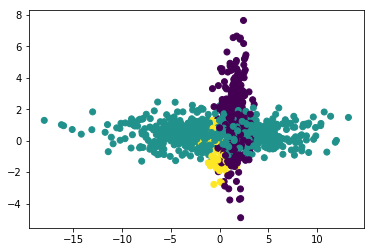

In [78]:
sess = ed.get_session()
mog1_sample = sess.run([v.value() for v in mog1]) # ancestral sampling

pi_true,mu_true,sigmasq_true,z_true,x_true = mog1_sample
# plot means
# plt.scatter(*mu_true.T,s=300)
# plot observation color coded by assignments
plt.scatter(*x_true.T, c=z_true)

In [54]:
def independentFactorAnalyzer(D=2,K=1,M=100,tau=1.,lamda=20.):
    lamda = lamda*tf.ones([K])
    sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
    w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
    z = Normal(tf.zeros([M, K]),    tf.ones([M, K]))
    mu = Normal(tf.zeros([D]),       tf.ones([D]))
    x = MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z, transpose_b=True)),mu), tf.reshape(tf.tile(sigma,[M]),[M,D]))
    return (w,z,mu,sigma,x)